# *IMPORTING LIBRARIES AND DEFINING FUNCTIONS*

In [ ]:
# --- Install Necessary Libraries ---
!pip install lime shap mlxtend imbalanced-learn --quiet
!pip install --quiet gdown
!pip install xgboost

# --- Standard Libraries ---
import math
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import gdown
import sklearn
import os

# --- Colab Specific ---
from google.colab import drive, files
from IPython.display import HTML, display

# --- Scikit-learn Preprocessing ---
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

# --- Scikit-learn Model Selection ---
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV,
    cross_val_score, learning_curve
)

# --- Scikit-learn Metrics ---
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc
)

# --- Scikit-learn Feature Selection & Inspection ---
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance

# --- Scikit-learn Models ---
from sklearn.linear_model import (
    LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier,
    RidgeClassifier, RidgeClassifierCV
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# --- XGBoost ---
from xgboost import XGBClassifier

# --- Visualization Enhancements ---
from mlxtend.plotting import plot_confusion_matrix

# --- Additional Metrics ---
from imblearn.metrics import specificity_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifier, RidgeClassifierCV, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


def adjust_ratio(df_malicious, df_benign, desired_ratio):
    total_desired = min(len(df_malicious)/desired_ratio, len(df_benign)/(1-desired_ratio))
    n_malicious = int(total_desired * desired_ratio)
    n_benign = int(total_desired * (1 - desired_ratio))

    df_mal = df_malicious.sample(n=n_malicious, random_state=42)
    df_ben = df_benign.sample(n=n_benign, random_state=42)

    return pd.concat([df_mal, df_ben]).sample(frac=1, random_state=42).reset_index(drop=True)



# *FEATURE SELECTION*

In [ ]:
column_y= 'label'

columns_x = ['packet_count', 'total_bytes', 'byte_mean', 'unique_bytes', 'compression_ratio', 'payload_entropy', 'mean_iat', 'max_pkt_len']

# *DATA PRE-PROCESSING*

## **DATA FECTH**

In [ ]:
# File IDs for your two datasets
benign_folder_id = '1a-elIKZ77U6PMI3vInWxkLS-b43BWCnW'
malicious_folder_id = '1liVKAcwB6ChAlUjMvCbivD9OEbQC6BMV'

# Download paths
benign_path = '/content/BENIGN-CSV'
malicious_path = '/content/MALICIOUS-CSV'

# Download all files from each folder
gdown.download_folder(f'https://drive.google.com/drive/folders/{benign_folder_id}', output='/content/BENIGN-CSV', quiet=False, use_cookies=False)
gdown.download_folder(f'https://drive.google.com/drive/folders/{malicious_folder_id}', output='/content/MALICIOUS-CSV', quiet=False, use_cookies=False)

benign_files = [os.path.join(benign_path, f) for f in os.listdir(benign_path) if f.endswith(".csv")]
malicious_files = [os.path.join(malicious_path, f) for f in os.listdir(malicious_path) if f.endswith(".csv")]

benign_files.sort()
malicious_files.sort()

print("Benign CSV files found:")
print(benign_files)
print("\nMalicious CSV files found:")
print(malicious_files)


benign1 = pd.concat(
    [pd.read_csv(f) for f in benign_files if "S1" in f],
    ignore_index=True
)

benign2 = pd.concat(
    [pd.read_csv(f) for f in benign_files if "S2" in f],
    ignore_index=True
)


malicious1 = pd.concat(
     [pd.read_csv(f) for f in malicious_files if "S1" in f],
     ignore_index=True
)




print("\nDataFrame shapes:")
print("benign1:", benign1.shape)
print("benign2:", benign2.shape)
print("malicious1:", malicious1.shape)


Retrieving folder contents


Processing file 1glgHzsojN9-8ZAluMFlpizIiqzZnTn7t gnb_mac_20250916_2HR_S1_BENIGN_flows.csv
Processing file 1QD6VzMVRS32ca34-8_2N2PC0pchKLSoj gnb_mac_20250916_2HR_S2_BENIGN_flows.csv
Processing file 11XhmbfnSHhUViSc07TNeX6wprh4NJC8q gnb_rlc_20250916_2HR_S1_BENIGN_flows.csv
Processing file 1oMaAPtbL3p5I7qJnJ4O75B2_zAHxORpG gnb_rlc_20250916_2HR_S2_BENIGN_flows.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1glgHzsojN9-8ZAluMFlpizIiqzZnTn7t
To: /content/BENIGN-CSV/gnb_mac_20250916_2HR_S1_BENIGN_flows.csv
100%|██████████| 25.9M/25.9M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QD6VzMVRS32ca34-8_2N2PC0pchKLSoj
To: /content/BENIGN-CSV/gnb_mac_20250916_2HR_S2_BENIGN_flows.csv
100%|██████████| 28.9M/28.9M [00:00<00:00, 70.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=11XhmbfnSHhUViSc07TNeX6wprh4NJC8q
To: /content/BENIGN-CSV/gnb_rlc_20250916_2HR_S1_BENIGN_flows.csv
100%|██████████| 20.6M/20.6M [00:00<00:00, 45.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oMaAPtbL3p5I7qJnJ4O75B2_zAHxORpG
To: /content/BENIGN-CSV/gnb_rlc_20250916_2HR_S2_BENIGN_flows.csv
100%|██████████| 23.1M/23.1M [00:00<00:00, 33.1MB/s]
Download completed
Retrieving folder contents


Processing file 14W84sGaH9IbYOD4jsBOsXks7AnYtfPK_ gnb_mac_20250925_2HR_S1_FLOOD_flows.csv
Processing file 1RBDrazxA6FbB8YzzDu0Ik16hrkxmSpj2 gnb_rlc_20250925_2HR_S1_FLOOD_flows.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14W84sGaH9IbYOD4jsBOsXks7AnYtfPK_
To: /content/MALICIOUS-CSV/gnb_mac_20250925_2HR_S1_FLOOD_flows.csv
100%|██████████| 90.1M/90.1M [00:04<00:00, 21.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RBDrazxA6FbB8YzzDu0Ik16hrkxmSpj2
To: /content/MALICIOUS-CSV/gnb_rlc_20250925_2HR_S1_FLOOD_flows.csv
100%|██████████| 81.5M/81.5M [00:01<00:00, 60.0MB/s]
Download completed


Benign CSV files found:
['/content/BENIGN-CSV/gnb_mac_20250916_2HR_S1_BENIGN_flows.csv', '/content/BENIGN-CSV/gnb_mac_20250916_2HR_S2_BENIGN_flows.csv', '/content/BENIGN-CSV/gnb_rlc_20250916_2HR_S1_BENIGN_flows.csv', '/content/BENIGN-CSV/gnb_rlc_20250916_2HR_S2_BENIGN_flows.csv']

Malicious CSV files found:
['/content/MALICIOUS-CSV/gnb_mac_20250925_2HR_S1_FLOOD_flows.csv', '/content/MALICIOUS-CSV/gnb_rlc_20250925_2HR_S1_FLOOD_flows.csv']

DataFrame shapes:
benign1: (117024, 32)
benign2: (131140, 32)
malicious1: (431911, 32)


## **ENCODING, NaN HANDLING AND DROPPING INVALID FLOW DURATION**









In [ ]:
dfs = [benign1, benign2, malicious1]

for i, df in enumerate(dfs):
    if "label" in df.columns:
        df["label"] = df["label"].map({"Benign": 0, "DoS": 1})
    df = df.fillna(0)
    if "flow_duration" in df.columns:
        df = df[df["flow_duration"] != 0].copy()
    dfs[i] = df

## **FEATURE ISOLATION**

In [ ]:
for i, df in enumerate(dfs):
    dfs[i] = df[columns_x + [column_y]].copy()
    print(dfs[i].shape)

(115114, 9)
(129019, 9)
(431240, 9)


## **DATA SHUFFLING**

In [ ]:
random_seed = 42

malicious1_section1 = dfs[2].iloc[:int(len(dfs[2]) * 0.6)]

section1 = pd.concat([dfs[0], malicious1_section1], ignore_index=True)
section1 = shuffle(section1, random_state=random_seed)
print("Section 1 shape:", section1.shape)

malicious1_section2 = dfs[2].iloc[int(len(dfs[2]) * 0.8):]

section2 = pd.concat([dfs[1], malicious1_section2], ignore_index=True)
section2 = shuffle(section2, random_state=random_seed)
print("Section 2 shape:", section2.shape)

Section 1 shape: (373858, 9)
Section 2 shape: (215267, 9)


## **DATA RATIO VARIABLES**

In [ ]:
ratio_train = 0.1
ratio_test = 0.2
malicious_ratio_train = 0.3
malicious_ratio_test = 0.3
train_test_split_ratio = 0.7

## **DATA RATIO ADJUSTING AND SAMPLING**

In [ ]:
train_df = section1
test_df = section2

train_df = train_df.sample(frac=ratio_train, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=ratio_test, random_state=42).reset_index(drop=True)

total_train = len(train_df)
total_test = len(test_df)
total_ratio_train_test = total_train / (total_train + total_test)

train_malicious = train_df[train_df['label'] == 1]
train_benign = train_df[train_df['label'] == 0]

test_malicious = test_df[test_df['label'] == 1]
test_benign = test_df[test_df['label'] == 0]

train_df = adjust_ratio(train_malicious, train_benign, malicious_ratio_train)
test_df = adjust_ratio(test_malicious, test_benign, malicious_ratio_test)


total = len(train_df) + len(test_df)
desired_train_size = int(total * train_test_split_ratio)
desired_test_size = total - desired_train_size

if len(train_df) > desired_train_size:
    train_df = train_df.sample(n=desired_train_size, random_state=42).reset_index(drop=True)

if len(test_df) > desired_test_size:
    test_df = test_df.sample(n=desired_test_size, random_state=42).reset_index(drop=True)

print("\nFinal sizes after ratio control:")
train_size = len(train_df)
test_size = len(test_df)
total_size = train_size + test_size
train_test_ratio = train_size / total_size if total_size > 0 else 0

print(f"Train Size: {train_size}")
print(f"Test Size: {test_size}")
print(f"Train/Test Ratio: {train_test_ratio:.2f}")

train_label_dist = train_df['label'].value_counts(normalize=True)
test_label_dist = test_df['label'].value_counts(normalize=True)

print("\nLabel distribution in Train set:")
print(train_label_dist)
print(f"Target malicious ratio (train): {malicious_ratio_train:.2f} | Actual: {train_label_dist.get(1,0):.2f}")

print("\nLabel distribution in Test set:")
print(test_label_dist)
print(f"Target malicious ratio (test): {malicious_ratio_test:.2f} | Actual: {test_label_dist.get(1,0):.2f}")

print("\nTrain/Test Split Ratio Check:")
print(f"Target: {train_test_split_ratio:.2f} | Actual: {train_test_ratio:.2f}")

if abs(train_test_ratio - train_test_split_ratio) > 0.05:
    print("WARNING: Train/Test ratio deviates from target by more than 5%")

if abs(train_label_dist.get(1,0) - malicious_ratio_train) > 0.05:
    print("WARNING: Malicious ratio in Train deviates from target by more than 5%")

if abs(test_label_dist.get(1,0) - malicious_ratio_test) > 0.05:
    print("WARNING: Malicious ratio in Test deviates from target by more than 5%")



Final sizes after ratio control:
Train Size: 18893
Test Size: 8635
Train/Test Ratio: 0.69

Label distribution in Train set:
label
0    0.699995
1    0.300005
Name: proportion, dtype: float64
Target malicious ratio (train): 0.30 | Actual: 0.30

Label distribution in Test set:
label
0    0.701679
1    0.298321
Name: proportion, dtype: float64
Target malicious ratio (test): 0.30 | Actual: 0.30

Train/Test Split Ratio Check:
Target: 0.70 | Actual: 0.69


## **NORMALIZATION**

In [ ]:
x_train = train_df.drop(columns=['label'])
y_train = train_df['label']

x_test = test_df.drop(columns=['label'])
y_test = test_df['label']


scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("\nData prepared:")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")




Data prepared:
x_train shape: (18893, 8), y_train shape: (18893,)
x_test shape: (8635, 8), y_test shape: (8635,)


# *MODEL TRAINING*

In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'LogisticRegressionCV': LogisticRegressionCV(max_iter=1000),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(),
    'RidgeClassifier': RidgeClassifier(),
    'RidgeClassifierCV': RidgeClassifierCV(),
    'Perceptron': Perceptron(),
    'SGDClassifier': SGDClassifier(),
    'Support Vector Machines': SVC(probability=True),
    'LinearSVC': LinearSVC(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'ExtraTreeClassifier': ExtraTreeClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'GaussianNB': GaussianNB(),
    'BernoulliNB': BernoulliNB(),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'XGBClassifier': XGBClassifier(eval_metric='logloss'),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=10),
}


metrics_results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Kappa': [],
    'Specificity': [],
    'ROC_AUC': []
}

for name, model in models.items():
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    cm = confusion_matrix(y_test, y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_test, y_pred, average='binary', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='binary', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)

    if cm.shape == (2, 2):
        TN = cm[0, 0]
        FP = cm[0, 1]
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    else:
        specificity = float('nan')

    if hasattr(model, "predict_proba"):
        try:
            y_scores = model.predict_proba(x_test_scaled)[:, 1]
            roc_auc = roc_auc_score(y_test, y_scores)
        except Exception:
            roc_auc = float('nan')
    elif hasattr(model, "decision_function"):
        try:
            y_scores = model.decision_function(x_test_scaled)
            roc_auc = roc_auc_score(y_test, y_scores)
        except Exception:
            roc_auc = float('nan')
    else:
        roc_auc = float('nan')

    metrics_results['Model'].append(name)
    metrics_results['Accuracy'].append(accuracy)
    metrics_results['Precision'].append(precision)
    metrics_results['Recall'].append(recall)
    metrics_results['F1-Score'].append(f1)
    metrics_results['Kappa'].append(kappa)
    metrics_results['Specificity'].append(specificity)
    metrics_results['ROC_AUC'].append(roc_auc)

metrics_df = pd.DataFrame(metrics_results).round(4)
metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)



# *RESULTS*

## **TABLE**

In [ ]:
display(metrics_df)

,Model,Accuracy,Precision,Recall,F1-Score,Kappa,Specificity,ROC_AUC
0,Support Vector Machines,0.9707,0.9371,0.9666,0.9517,0.9306,0.9724,0.9881
1,KNeighborsClassifier,0.9647,0.9254,0.9589,0.9418,0.9165,0.9672,0.9801
2,QuadraticDiscriminantAnalysis,0.9362,0.8932,0.8929,0.8930,0.8476,0.9546,0.9673
3,LinearDiscriminantAnalysis,0.9180,0.9036,0.8117,0.8552,0.7983,0.9632,0.9746
4,RidgeClassifierCV,0.9128,0.9042,0.7915,0.8441,0.7840,0.9644,0.9746
5,RidgeClassifier,0.9128,0.9042,0.7915,0.8441,0.7840,0.9644,0.9746
6,ExtraTreeClassifier,0.9056,0.9207,0.7481,0.8254,0.7617,0.9726,0.8603
7,ExtraTreesClassifier,0.8492,0.9241,0.5388,0.6807,0.5908,0.9812,0.9854
8,RandomForestClassifier,0.8221,0.9788,0.4127,0.5806,0.4904,0.9962,0.9858
9,BaggingClassifier,0.8089,0.9575,0.3762,0.5401,0.4471,0.9929,0.7202


## **CONFUSION MATRIXES**

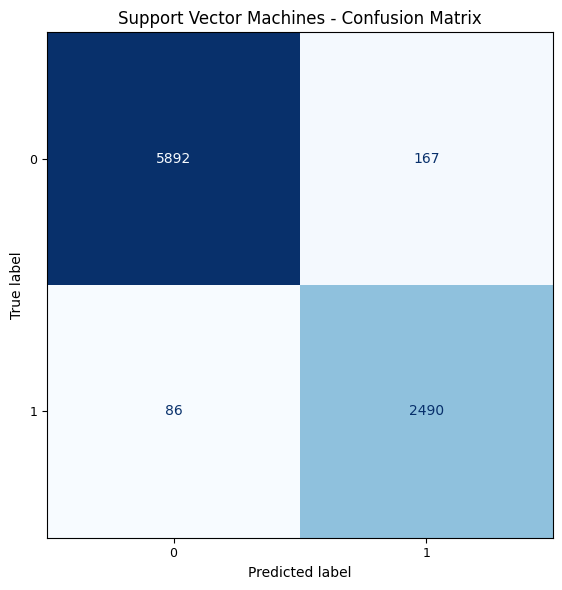

In [ ]:
svm_model = models['Support Vector Machines']
y_pred_svm = svm_model.predict(x_test_scaled)
cm_svm = confusion_matrix(y_test, y_pred_svm)

fig, ax = plt.subplots(figsize=(6, 6))
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(ax=ax, cmap='Blues', colorbar=False, values_format='d')

ax.set_title('Support Vector Machines - Confusion Matrix', fontsize=12)
ax.set_xlabel('Predicted label', fontsize=10)
ax.set_ylabel('True label', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)
ax.grid(False)

plt.tight_layout()
plt.show()
plt.close(fig)

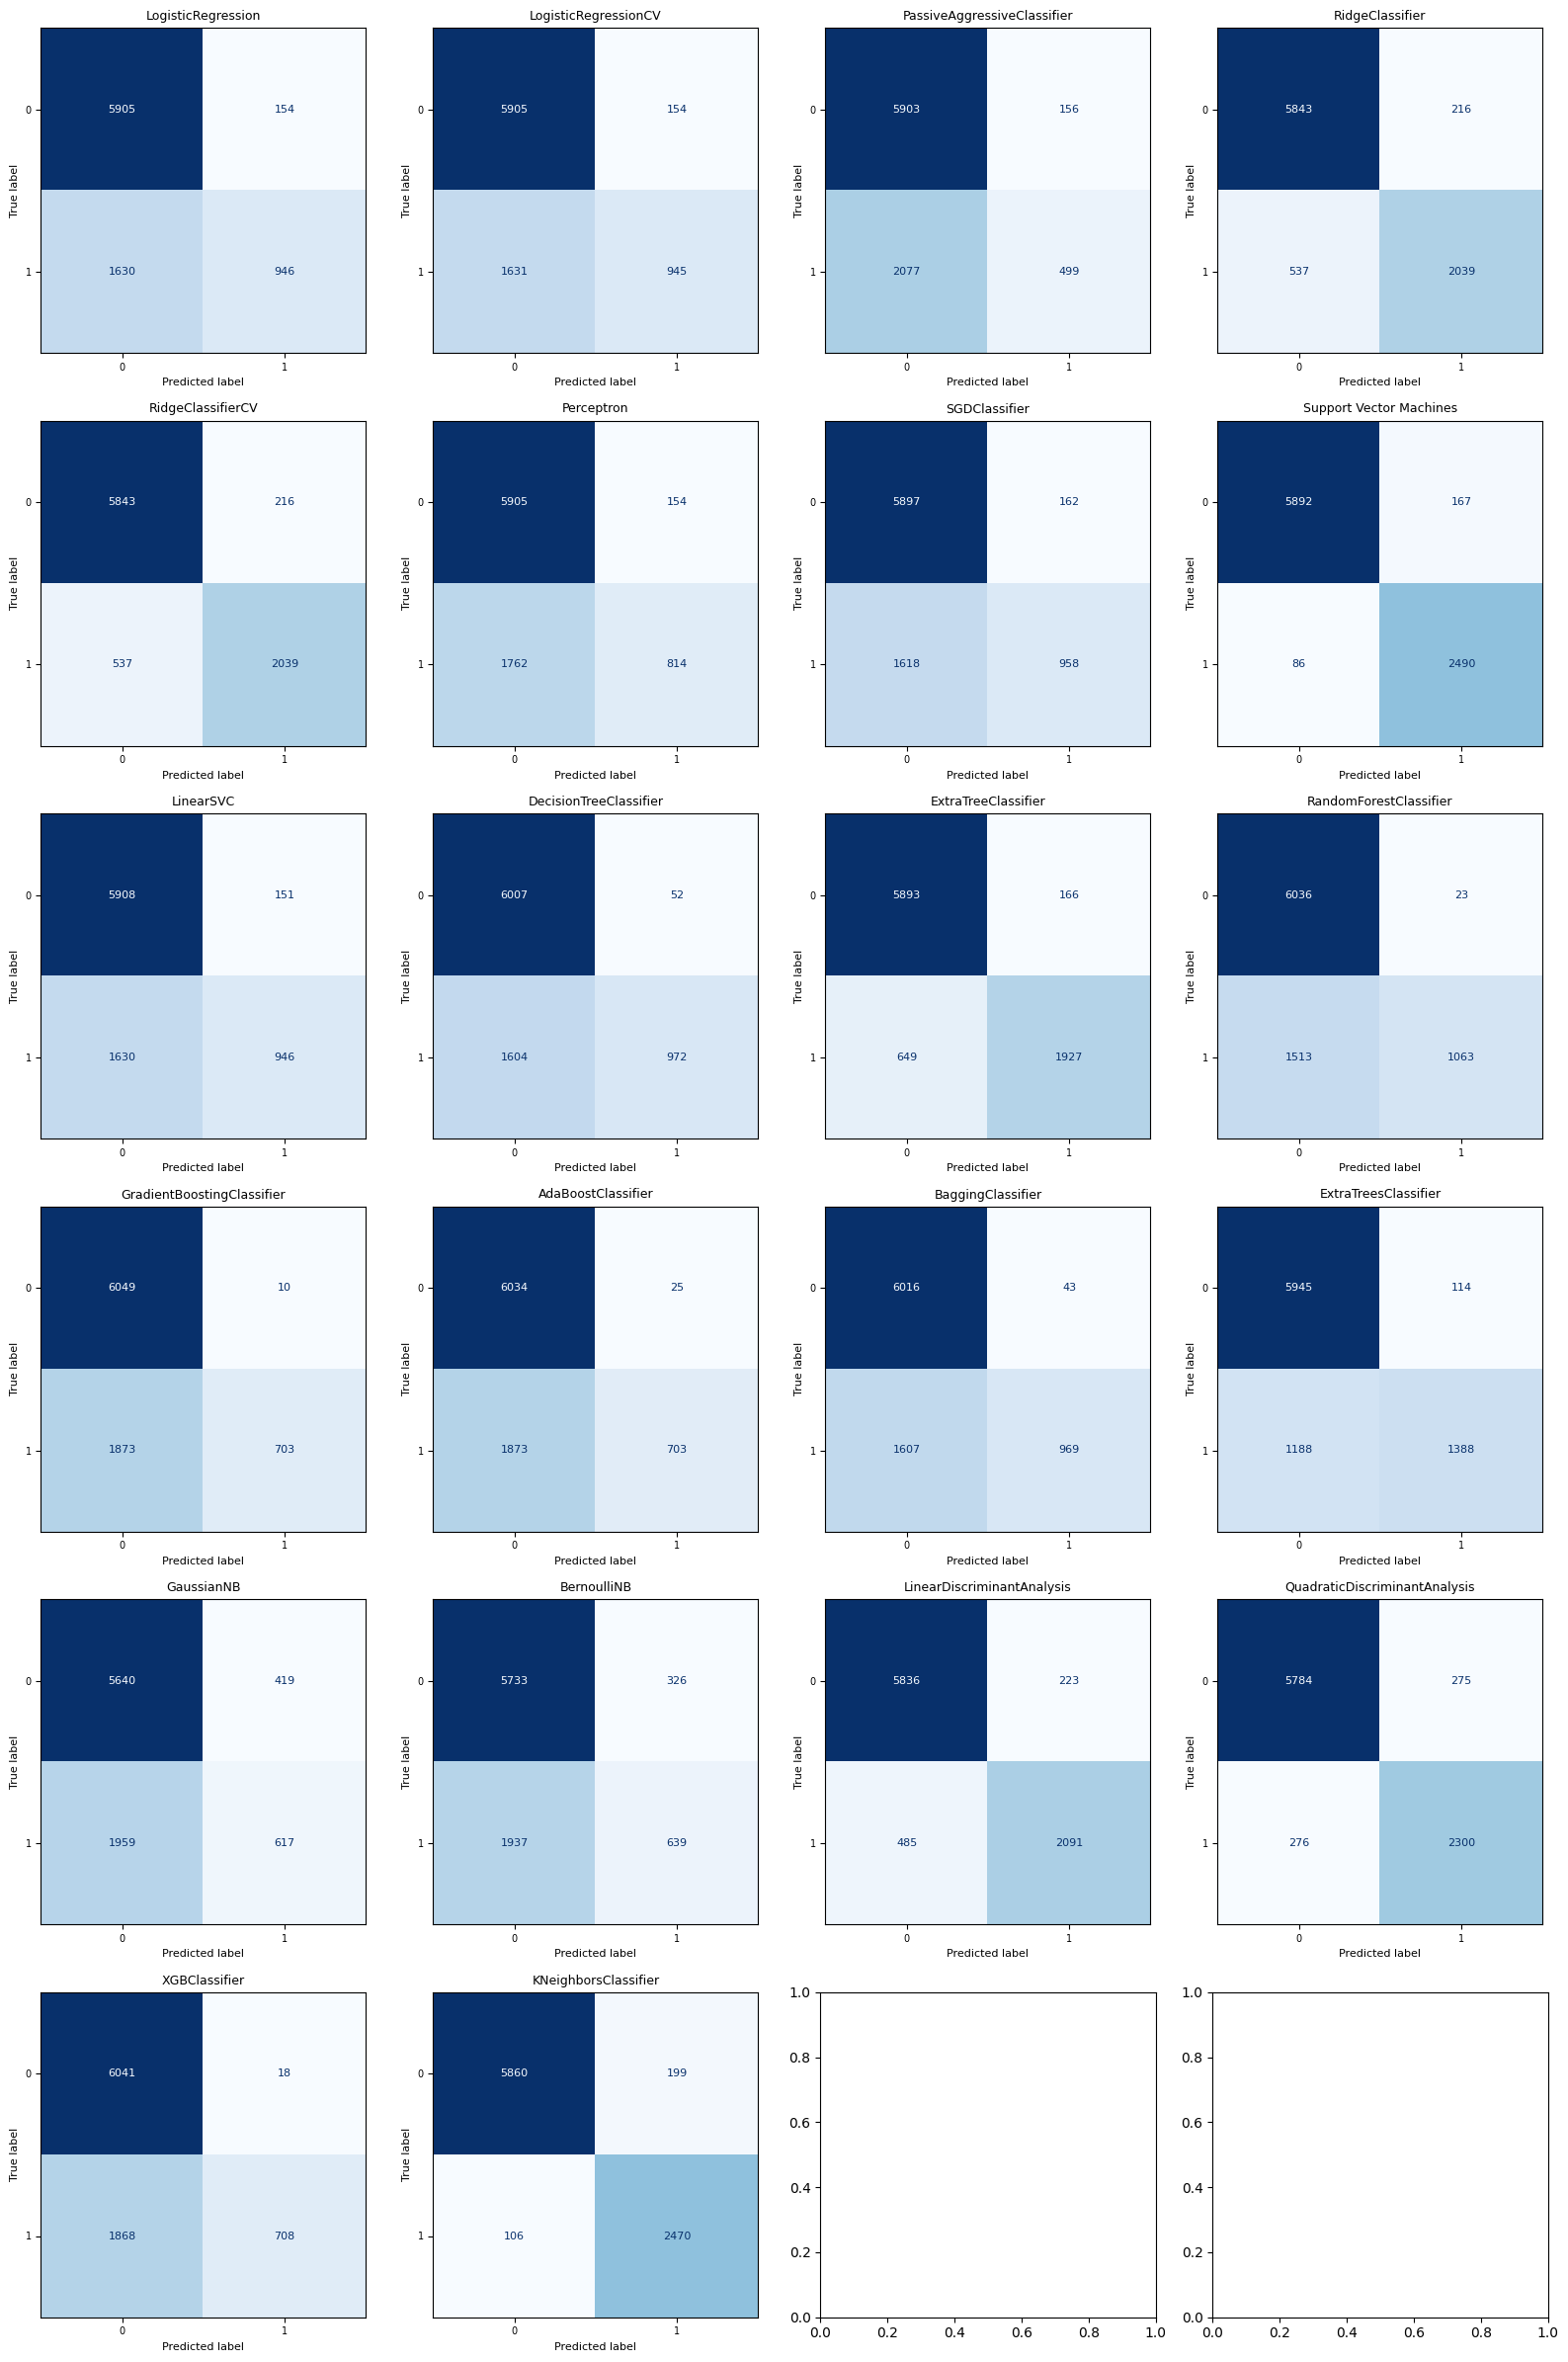

In [ ]:
n_models = len(models)
cols = 4
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    y_pred = model.predict(x_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[idx], cmap='Blues', colorbar=False, values_format='d')


    axes[idx].set_title(f'{name}', fontsize=9)
    axes[idx].set_xlabel('Predicted label', fontsize=8)
    axes[idx].set_ylabel('True label', fontsize=8)
    axes[idx].tick_params(axis='both', which='major', labelsize=7)
    for text in axes[idx].texts:
        text.set_fontsize(8)

    axes[idx].grid(False)

plt.tight_layout()
plt.show()
plt.close(fig)
